# Using MCMC for regression of !Kung adults' height on their weight

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

In [2]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map = {"Alpha": r"$\alpha$", "Beta": r"$\beta$"})

In [3]:
ALPHA = 0.11

Data

In [4]:
Dat = pd.read_csv('Data/Howell1.csv', sep=';')
DatAdults = Dat[Dat['age'] >= 18].sort_values('weight').reset_index(drop=True) # We are interested in adult's height

---

Fit the model and sample from the prior predictive.

In [5]:
with pm.Model() as ModelHeightWeight:
    Alpha    = pm.Normal('Alpha', mu=170, sigma=10)
    Beta     = pm.Gamma('Beta', alpha=5, beta=5)
    Sigma    = pm.Uniform('Sigma', lower=0, upper=10)
    Mu       = pm.Deterministic('Mu', Alpha + Beta * (DatAdults['weight'] - DatAdults['weight'].mean()))
    Height   = pm.Normal('Height', mu=Mu, sigma=Sigma, observed=DatAdults['height'])

    TraceModelHeightWeight = pm.sample_prior_predictive()   

Sampling: [Alpha, Beta, Height, Sigma]


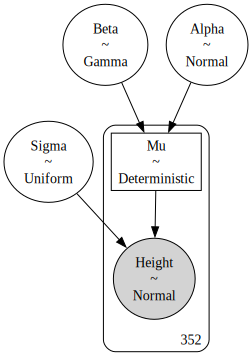

In [6]:
pm.model_to_graphviz(ModelHeightWeight)

Text(0, 0.5, 'Average height')

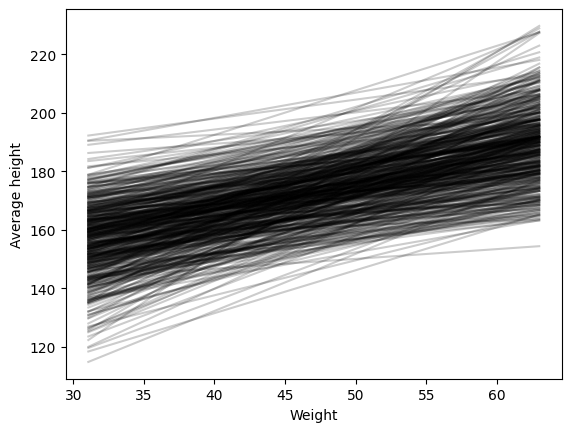

In [7]:
x_min, x_max = DatAdults['weight'].min(), DatAdults['weight'].max()
x = np.linspace(x_min-DatAdults['weight'].mean(), x_max-DatAdults['weight'].mean())

PriorAlpha = TraceModelHeightWeight.prior.Alpha.values[0]
PriorBeta = TraceModelHeightWeight.prior.Beta.values[0]

for a, b in zip(PriorAlpha, PriorBeta):
    y = a + b*x

    plt.plot(x+DatAdults['weight'].mean(), y, c='k', alpha=0.2)

plt.xlabel('Weight')
plt.ylabel('Average height')

Sample from the posterior

In [8]:
with ModelHeightWeight:
    TraceModelHeightWeight.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: >, None],
       [<Axes: xlabel='$\\alpha$', ylabel='$\\beta$'>, <Axes: >]],
      dtype=object)

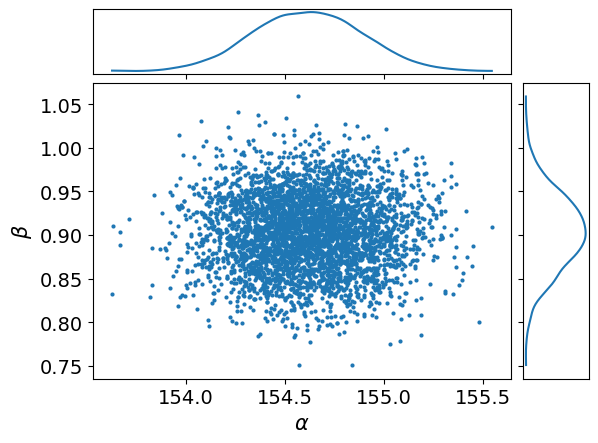

In [9]:
az.plot_pair(TraceModelHeightWeight, var_names=['Alpha', 'Beta'], marginals=True, labeller=labeller)

array([[<Axes: >, None],
       [<Axes: xlabel='$\\alpha$', ylabel='$\\beta$'>, <Axes: >]],
      dtype=object)

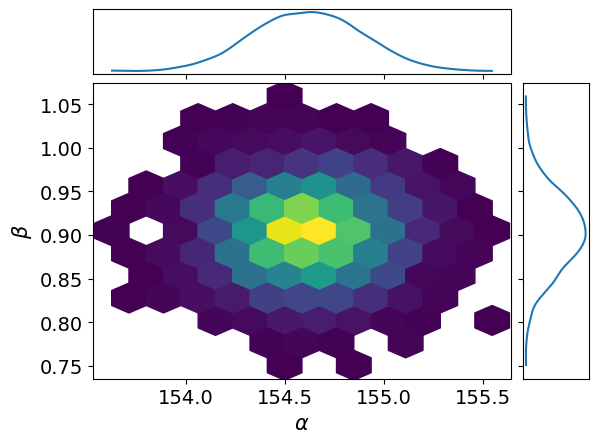

In [10]:
az.plot_pair(TraceModelHeightWeight, var_names=['Alpha', 'Beta'], kind="hexbin", marginals=True, labeller=labeller)

Posterior interval of $1-\alpha$ of probability.

In [11]:
az.summary(TraceModelHeightWeight, hdi_prob=1-ALPHA, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
Alpha,154.616,0.275,154.201,155.065
Beta,0.903,0.043,0.836,0.971
Sigma,5.107,0.194,4.777,5.392
Mu[0],142.045,0.656,141.061,143.117
Mu[1],142.455,0.638,141.448,143.451
...,...,...,...,...
Mu[347],167.110,0.651,166.097,168.187
Mu[348],167.776,0.680,166.686,168.869
Mu[349],167.955,0.688,166.853,169.061
Mu[350],169.798,0.769,168.596,171.044


Sample from the predictive posterior

In [12]:
with ModelHeightWeight:
    TraceModelHeightWeight.extend(pm.sample_posterior_predictive(TraceModelHeightWeight))

Sampling: [Height]


Plot the posterior predictive

<Axes: xlabel='Height / Height'>

/usr/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


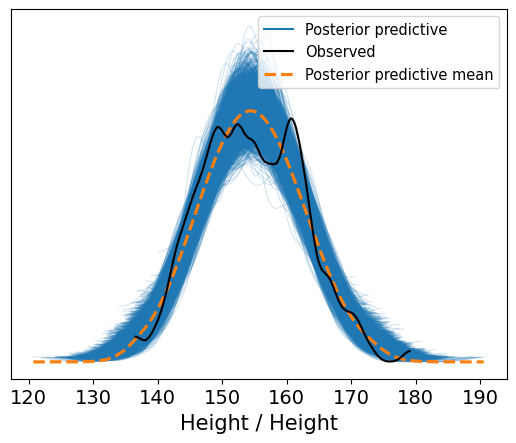

In [13]:
az.plot_ppc(TraceModelHeightWeight)

Plot the regression function with confidence and prediction intervals

Text(0, 0.5, 'Height')

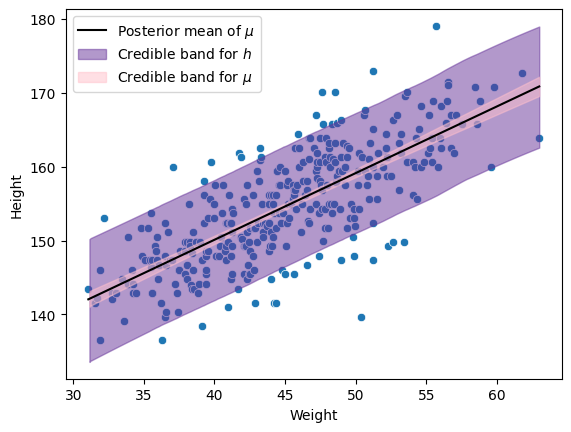

In [15]:
sns.scatterplot(x=DatAdults['weight'], y=DatAdults['height'])

plt.plot(
    DatAdults['weight']
    , TraceModelHeightWeight.posterior.Mu.mean(('chain', 'draw'))
    , label=r"Posterior mean of $\mu$"
    , color='k'
)

az.plot_hdi(
    DatAdults['weight']
    , TraceModelHeightWeight.posterior_predictive.Height
    , hdi_prob=1-ALPHA
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':r"Credible band for $h$"}
)

az.plot_hdi(
    DatAdults['weight']
    , TraceModelHeightWeight.posterior.Mu
    , hdi_prob=1-ALPHA
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label':r"Credible band for $\mu$"}
)

plt.legend()

plt.xlabel('Weight')
plt.ylabel('Height')